In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
from dce import DCE
from cluster import Cluster
from descriptor import rdkitDescriptors
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


### Basic cleaning using utility function  
* Use only int features
* Use 60% BOD as cutoff for ground true labeling
* Clean unique input columns

In [2]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
feat_int = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='int')
#selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]

In [3]:
feat_int.shape

(1063, 61)

* Clean unique input columns calling from utility function

In [4]:
selected_feat_int=utilities.dedup_input_cols(feat_int)

In [5]:
selected_feat_int.shape # only 59 features

(1063, 59)

In [21]:
selected_feat_int.describe()

,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumRings,NumHeteroatoms,NumAmideBonds,NumAromaticRings,NumHBA,NumAliphaticRings,NumSaturatedRings,...,MQN32,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN40,MQN41,MQN42
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2.462841,0.913452,3.785513,1.050800,3.348071,0.099718,0.809031,2.209784,0.241769,0.156162,...,0.060207,0.031985,0.003763,0.119473,0.884290,0.001881,0.003763,0.005644,0.392286,0.226717
std,2.087602,1.234332,5.866459,1.089782,2.882053,0.431166,0.932886,1.904059,0.644304,0.498658,...,0.400267,0.239492,0.061256,0.442373,0.941194,0.043355,0.061256,0.086609,1.372111,0.908405
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,2.000000,1.000000,3.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,1.000000,4.000000,2.000000,4.000000,0.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,15.000000,8.000000,64.000000,10.000000,29.000000,4.000000,6.000000,13.000000,5.000000,4.000000,...,6.000000,4.000000,1.000000,4.000000,6.000000,1.000000,1.000000,2.000000,21.000000,14.000000


### label BOD with desired partition

(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

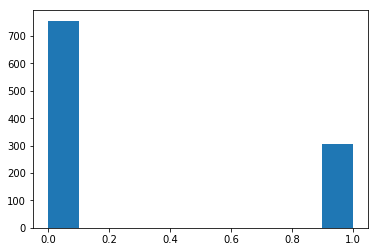

In [6]:
df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

### Build baseline cluster model

In [7]:
from cluster import KMeans

In [15]:
kmeans_cluster = KMeans(n_clusters=2)

* Without normalization

In [106]:
kmeans_cluster.bulid_model()
results = kmeans_cluster.train_model(selected_feat_int.values, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.5631770710744006
calinski score: 662.268614258969

Metric with True label
adjusted rand score: 0.009059296119767083 
fowlkes_mallows : 0.6768485965891258


(array([923.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 140.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

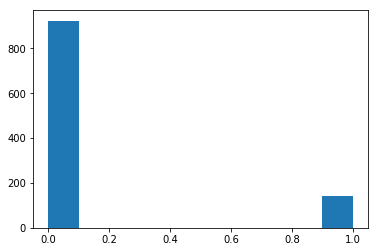

In [107]:
plt.hist(results[0])

* With normalization

In [58]:
from keras.utils import normalize
selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=100)

** Example of keras normalize

In [59]:
data = np.array([
    [1000, 10, 0.5],
    [765, 5, 0.35],
    [800, 7, 0.09], ])

In [62]:
normalize(data, axis=0, order=100) # order >80 to represent min-max normalization

array([[1.   , 1.   , 1.   ],
       [0.765, 0.5  , 0.7  ],
       [0.8  , 0.7  , 0.18 ]])

In [61]:
pd.DataFrame(selected_feat_int_norm).describe()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,0.164188,0.114182,0.059149,0.105080,0.115417,0.024586,0.134839,0.169981,0.047825,0.038614,...,0.009965,0.007996,0.003711,0.029391,0.147382,0.001868,0.003711,0.002822,0.018680,0.016194
std,0.139172,0.154292,0.091663,0.108978,0.099352,0.106307,0.155481,0.146464,0.127453,0.123303,...,0.066250,0.059873,0.060413,0.108828,0.156866,0.043056,0.060413,0.043304,0.065339,0.064886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.066666,0.000000,0.015625,0.000000,0.068945,0.000000,0.000000,0.076922,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.133332,0.000000,0.031250,0.100000,0.103418,0.000000,0.166667,0.153844,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.266664,0.125000,0.062500,0.200000,0.137890,0.000000,0.166667,0.230765,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.999990,1.000000,1.000000,1.000000,0.999705,0.986233,1.000000,0.999983,0.989074,0.989074,...,0.993092,1.000000,0.986233,0.984034,1.000000,0.993092,0.986233,1.000000,1.000000,1.000000


In [75]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_model()
temp_outcome=kmeans_cluster.train_model(selected_feat_int_norm, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.23900635324388148
calinski score: 166.13134304252884

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028


In [78]:
temp_outcome[1]['adjusted_rand_score']

-0.0284578216480051

#### Test how normalization order affect the results

In [90]:
ad_rand_score = []
silhouettes= []
for i in range(-2,80):
    selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=i)
    kmeans_cluster = KMeans(n_clusters=2)
    kmeans_cluster.bulid_model()
    temp_outcome = kmeans_cluster.train_model(selected_feat_int_norm, true_labels=true_label_biclass)
    ad_rand_score.append(temp_outcome[1]['adjusted_rand_score'])
    silhouettes.append(temp_outcome[1]['silhouette_score'])

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in power
  absx **= ord


Metrics without ture labels
silhouette score: 0.6285788790114298
calinski score: 1295.8554805705685

Metric with True label
adjusted rand score: -0.01823499535728975 
fowlkes_mallows : 0.64336148456634


C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in reciprocal
  absx **= ord


Metrics without ture labels
silhouette score: 0.6563290323083916
calinski score: 1432.3552598931533

Metric with True label
adjusted rand score: -0.021189539063848843 
fowlkes_mallows : 0.6457692240635479
Metrics without ture labels
silhouette score: 0.938609456318244
calinski score: 1658.273644097982

Metric with True label
adjusted rand score: -0.00868493415254232 
fowlkes_mallows : 0.7592277000556553
Metrics without ture labels
silhouette score: 0.9357032559581484
calinski score: 244.2118038721719

Metric with True label
adjusted rand score: 0.0016215088477707466 
fowlkes_mallows : 0.7663380586804177
Metrics without ture labels
silhouette score: 0.42662489205378124
calinski score: 116.59213501508897

Metric with True label
adjusted rand score: -0.0072175321765158736 
fowlkes_mallows : 0.6863043742455759
Metrics without ture labels
silhouette score: 0.2699592983605325
calinski score: 120.7037839652916

Metric with True label
adjusted rand score: -0.05138019448648896 
fowlkes_mallows 

silhouette score: 0.23871614144055586
calinski score: 166.33598164910183

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028
Metrics without ture labels
silhouette score: 0.23873007641344304
calinski score: 166.33497446587117

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028
Metrics without ture labels
silhouette score: 0.23874316468588358
calinski score: 166.33338421755758

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028
Metrics without ture labels
silhouette score: 0.23875547567772562
calinski score: 166.33129267603363

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028
Metrics without ture labels
silhouette score: 0.2387670719523645
calinski score: 166.3287713811699

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028
Metrics wi

calinski score: 166.18721457100014

Metric with True label
adjusted rand score: -0.0284578216480051 
fowlkes_mallows : 0.5796000850663028


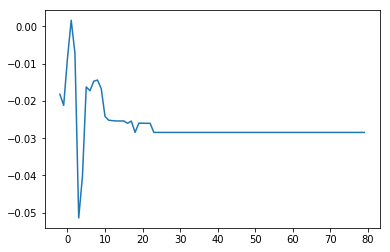

In [91]:
plt.plot(list(range(-2,80)), ad_rand_score)

(-2, 10)

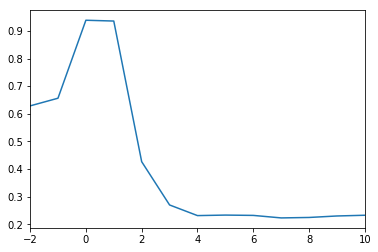

In [97]:
plt.plot(list(range(-2,80)), silhouettes)
plt.xlim(-2, 10)

In [98]:
pd.DataFrame(normalize(selected_feat_int.values, axis=0, order=1)).describe()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,...,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,...,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941,0.000941
std,0.000797,0.001271,0.001458,0.000976,0.000810,0.004068,0.001085,0.000811,0.002507,0.003004,...,0.006254,0.007044,0.015314,0.003483,0.001001,0.021678,0.015314,0.014435,0.003290,0.003769
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000382,0.000000,0.000249,0.000000,0.000562,0.000000,0.000000,0.000426,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000764,0.000000,0.000497,0.000895,0.000843,0.000000,0.001163,0.000851,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001064,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.001528,0.001030,0.000994,0.001791,0.001124,0.000000,0.001163,0.001277,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001064,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.005730,0.008239,0.015905,0.008953,0.008148,0.037736,0.006977,0.005534,0.019455,0.024096,...,0.093750,0.117647,0.250000,0.031496,0.006383,0.500000,0.250000,0.333333,0.050360,0.058091


In [123]:
selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=0) #select order=0 for the best silhuette score

In [124]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_model()
temp_outcome = kmeans_cluster.train_model(selected_feat_int_norm, true_labels=true_label_biclass)

Metrics without ture labels
silhouette score: 0.938609456318244
calinski score: 1658.273644097982

Metric with True label
adjusted rand score: -0.00868493415254232 
fowlkes_mallows : 0.7592277000556553


(array([1055.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

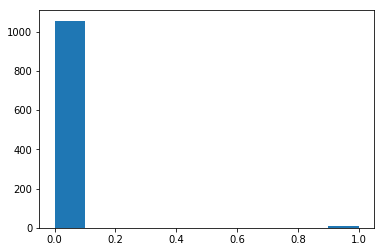

In [127]:
plt.hist(temp_outcome[0]) # but the distribution does not agree with the original label distribution AND adjusted rand score is bad

### dce model

In [128]:
autoencoder_dims = [59,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
dce.build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [129]:
dce.model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 59)           0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 59)           236         input[0][0]                      
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 45)           2700        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
embedding_layer (Dense)         (None, 20)           920         encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_1 

In [131]:
[y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)

Instructions for updating:
Use tf.cast instead.
Epoch: 0
  Total_loss = 0.008127097;Delta_label = 0.0
  Clustering_loss = 0.00016264408; Decoder_loss = 0.01609155
Epoch: 25
  Total_loss = 0.00052470725;Delta_label = 0.1702728127939793
  Clustering_loss = 8.771115e-06; Decoder_loss = 0.0010406434
Epoch: 50
  Total_loss = 0.0004430084;Delta_label = 0.05644402634054563
  Clustering_loss = 1.9301662e-05; Decoder_loss = 0.00086671516
Epoch: 75
  Total_loss = 0.00044250663;Delta_label = 0.07902163687676388
  Clustering_loss = 6.8799476e-05; Decoder_loss = 0.0008162138
Epoch: 100
  Total_loss = 0.0005167383;Delta_label = 0.08936970837253057
  Clustering_loss = 0.0002644112; Decoder_loss = 0.0007690654
Epoch: 125
  Total_loss = 0.00087196846;Delta_label = 0.045155221072436504
  Clustering_loss = 0.0010051723; Decoder_loss = 0.0007387647
Epoch: 150
  Total_loss = 0.0020470787;Delta_label = 0.04985888993414864
  Clustering_loss = 0.0033730257; Decoder_loss = 0.0007211317
Epoch: 175
  Total_loss 

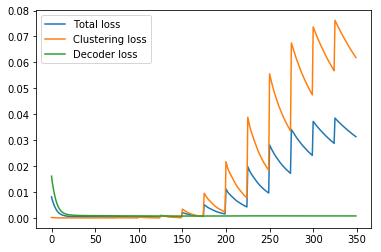

In [132]:
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()

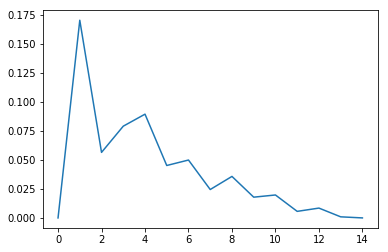

In [133]:
plt.plot(delta_label)


(array([508.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 555.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

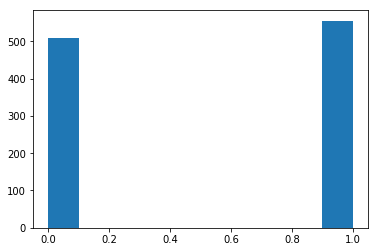

In [134]:
plt.hist(y_pred)


In [135]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)


Metric with True label
adjusted rand score: 0.000834963595056379 
fowlkes_mallows : 0.543255217409827


{'adjusted_rand_score': 0.000834963595056379,
 'fowlkes_mallows_score': 0.543255217409827}

In [137]:
Cluster.no_label_metrics(selected_feat_int, y_pred, print_metric=True)

Metrics without ture labels
silhouette score: 0.03614558607890322
calinski score: 16.894826568392805


{'silhouette_score': 0.03614558607890322, 'calinski_score': 16.894826568392805}

### Same parameter for normalized data order = 0

Epoch: 0
  Total_loss = 0.015591982;Delta_label = 0.0
  Clustering_loss = 0.0002740092; Decoder_loss = 0.030909954
Epoch: 25
  Total_loss = 0.00067973236;Delta_label = 0.18626528692380057
  Clustering_loss = 1.3102276e-05; Decoder_loss = 0.0013463624
Epoch: 50
  Total_loss = 0.00048587812;Delta_label = 0.06867356538099718
  Clustering_loss = 3.1297255e-05; Decoder_loss = 0.00094045897
Epoch: 75
  Total_loss = 0.00048633548;Delta_label = 0.05832549388523048
  Clustering_loss = 0.00010477651; Decoder_loss = 0.00086789444
Epoch: 100
  Total_loss = 0.0006169959;Delta_label = 0.03198494825964252
  Clustering_loss = 0.000403241; Decoder_loss = 0.0008307508
Epoch: 125
  Total_loss = 0.0012190619;Delta_label = 0.04045155221072436
  Clustering_loss = 0.0016283952; Decoder_loss = 0.0008097285
Epoch: 150
  Total_loss = 0.0032321867;Delta_label = 0.03386641580432737
  Clustering_loss = 0.0056500346; Decoder_loss = 0.00081433845
Epoch: 175
  Total_loss = 0.008331884;Delta_label = 0.0357478833490122

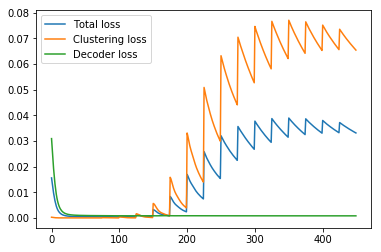

In [139]:
autoencoder_dims = [59,45,20]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
dce.build_model()
[y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)
plt.plot(loss[0], label='Total loss')
plt.plot(loss[1], label='Clustering loss')
plt.plot(loss[2], label='Decoder loss')
plt.legend()




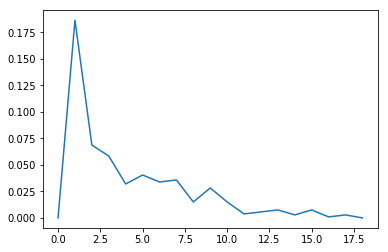

In [143]:
plt.plot(delta_label)


(array([504.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 559.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

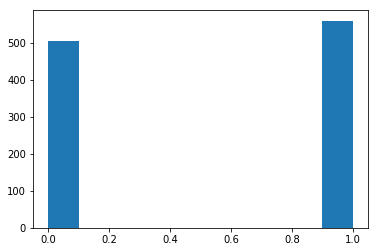

In [144]:
plt.hist(y_pred)

In [142]:
Cluster.true_label_metrics(true_label_biclass,y_pred,print_metric=True)
Cluster.no_label_metrics(selected_feat_int_norm, y_pred, print_metric=True)

Metric with True label
adjusted rand score: 0.01538022852295646 
fowlkes_mallows : 0.550144819683573
Metrics without ture labels
silhouette score: 0.07287341846189183
calinski score: 10.104416975180637


{'silhouette_score': 0.07287341846189183, 'calinski_score': 10.104416975180637}

In [147]:
Cluster.true_label_metrics(true_label_biclass, y_pred, print_metric=True)['adjusted_rand_score']

Metric with True label
adjusted rand score: 0.01538022852295646 
fowlkes_mallows : 0.550144819683573


0.01538022852295646

Better adjusted rand score for normalized data

In [154]:
adjusted_rands = []
for i in range(-2,10):
    selected_feat_int_norm = normalize(selected_feat_int.values, axis=0, order=i)
    dce = DCE(autoencoder_dims, n_clusters=2, update_interval=50)
    dce.build_model()
    [y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=0.5)
    adjusted_rands.append(Cluster.true_label_metrics(true_label_biclass, y_pred, print_metric=True)['adjusted_rand_score'])

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in power
  absx **= ord


Epoch: 0
  Total_loss = 0.010350223;Delta_label = 0.0
  Clustering_loss = 0.0001903286; Decoder_loss = 0.020510117
Epoch: 50
  Total_loss = 0.0004521008;Delta_label = 0.19943555973659455
  Clustering_loss = 7.6084384e-06; Decoder_loss = 0.00089659315
Epoch: 100
  Total_loss = 0.00040876836;Delta_label = 0.06114769520225776
  Clustering_loss = 2.7611124e-05; Decoder_loss = 0.00078992563
Epoch: 150
  Total_loss = 0.00040839973;Delta_label = 0.030103480714957668
  Clustering_loss = 0.00010589828; Decoder_loss = 0.00071090116
Epoch: 200
  Total_loss = 0.0005318459;Delta_label = 0.01975540921919097
  Clustering_loss = 0.00041028942; Decoder_loss = 0.00065340236
Epoch: 250
  Total_loss = 0.001068021;Delta_label = 0.01317027281279398
  Clustering_loss = 0.001524397; Decoder_loss = 0.0006116451
Epoch: 300
  Total_loss = 0.002931247;Delta_label = 0.01881467544684854
  Clustering_loss = 0.0052729556; Decoder_loss = 0.00058953837
Epoch: 350
  Total_loss = 0.008000045;Delta_label = 0.0225776105362

C:\Users\Yang\.conda\envs\deepchembed\lib\site-packages\numpy\linalg\linalg.py:2488: RuntimeWarning: divide by zero encountered in reciprocal
  absx **= ord


Epoch: 0
  Total_loss = 0.013650178;Delta_label = 0.0
  Clustering_loss = 0.0005747296; Decoder_loss = 0.026725626
Epoch: 50
  Total_loss = 0.00048379775;Delta_label = 0.17403574788334902
  Clustering_loss = 2.3315366e-05; Decoder_loss = 0.0009442801
Epoch: 100
  Total_loss = 0.0004438042;Delta_label = 0.06114769520225776
  Clustering_loss = 7.5527656e-05; Decoder_loss = 0.00081208075
Epoch: 150
  Total_loss = 0.0005158157;Delta_label = 0.04609595484477893
  Clustering_loss = 0.00027481338; Decoder_loss = 0.000756818
Epoch: 200
  Total_loss = 0.00088065193;Delta_label = 0.02539981185324553
  Clustering_loss = 0.0010434618; Decoder_loss = 0.000717842
Epoch: 250
  Total_loss = 0.0022375896;Delta_label = 0.015051740357478834
  Clustering_loss = 0.0037976652; Decoder_loss = 0.000677514
Epoch: 300
  Total_loss = 0.00632778;Delta_label = 0.01599247412982126
  Clustering_loss = 0.011990333; Decoder_loss = 0.0006652272
Epoch: 350
  Total_loss = 0.014648219;Delta_label = 0.02916274694261524
  C

  Clustering_loss = 0.06896191; Decoder_loss = 0.00070712744
Epoch: 550
  Total_loss = 0.034777466;Delta_label = 0.004703668861712135
  Clustering_loss = 0.068823844; Decoder_loss = 0.0007310867
Epoch: 600
  Total_loss = 0.033164404;Delta_label = 0.0028222013170272815
  Clustering_loss = 0.06560784; Decoder_loss = 0.00072096795
Epoch: 650
  Total_loss = 0.03131577;Delta_label = 0.0018814675446848542
  Clustering_loss = 0.06192503; Decoder_loss = 0.00070651225
Epoch: 700
  Total_loss = 0.02950247;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.058307208; Decoder_loss = 0.0006977315
Epoch: 750
  Total_loss = 0.027846457;Delta_label = 0.0028222013170272815
  Clustering_loss = 0.054999974; Decoder_loss = 0.0006929413
Epoch: 800
  Total_loss = 0.026338091;Delta_label = 0.0018814675446848542
  Clustering_loss = 0.05198987; Decoder_loss = 0.0006863127
Epoch: 850
  Total_loss = 0.025010081;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.049346067; Decoder_loss = 0.000674093

Epoch: 700
  Total_loss = 0.027603528;Delta_label = 0.004703668861712135
  Clustering_loss = 0.05448664; Decoder_loss = 0.0007204166
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Metric with True label
adjusted rand score: 0.006909113135717661 
fowlkes_mallows : 0.5475843800878833
Epoch: 0
  Total_loss = 0.0099207265;Delta_label = 0.0
  Clustering_loss = 0.0011975965; Decoder_loss = 0.018643856
Epoch: 50
  Total_loss = 0.0004707953;Delta_label = 0.1251175917215428
  Clustering_loss = 1.646769e-05; Decoder_loss = 0.0009251229
Epoch: 100
  Total_loss = 0.00042180243;Delta_label = 0.07243650047036689
  Clustering_loss = 4.53406e-05; Decoder_loss = 0.0007982642
Epoch: 150
  Total_loss = 0.00044085132;Delta_label = 0.08936970837253057
  Clustering_loss = 0.0001590382; Decoder_loss = 0.00072266447
Epoch: 200
  Total_loss = 0.00063189596;Delta_label = 0.047036688617121354
  Clustering_loss = 0.00059128116; Decoder_loss = 0.0006725108
Epoch: 250
  Total_loss = 0.0014179454;Delta

  Total_loss = 0.034519367;Delta_label = 0.007525870178739417
  Clustering_loss = 0.06828523; Decoder_loss = 0.0007535034
Epoch: 500
  Total_loss = 0.036453072;Delta_label = 0.0037629350893697085
  Clustering_loss = 0.07215932; Decoder_loss = 0.00074682414
Epoch: 550
  Total_loss = 0.036178745;Delta_label = 0.004703668861712135
  Clustering_loss = 0.07161574; Decoder_loss = 0.0007417482
Epoch: 600
  Total_loss = 0.03496343;Delta_label = 0.004703668861712135
  Clustering_loss = 0.06918464; Decoder_loss = 0.00074221706
Epoch: 650
  Total_loss = 0.033443175;Delta_label = 0.0028222013170272815
  Clustering_loss = 0.06614455; Decoder_loss = 0.00074180093
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Metric with True label
adjusted rand score: 0.0002543653082173253 
fowlkes_mallows : 0.5429437063827224


In [ ]:
### The adjusted rand score vs. normalization order is not reproducible over the training

### parameter tuning for non-normalized int feature

In [158]:
ad_rands=[]
for i in np.arange(0,1.1,0.2):
    autoencoder_dims = [59,45,20]
    dce = DCE(autoencoder_dims, n_clusters=2, update_interval=25)
    dce.build_model()
    [y_pred, loss, delta_label] = dce.train_model(selected_feat_int.values,clustering_loss='kld', 
                                              decoder_loss='mse', clustering_loss_weight=i)
    adjusted_rands.append((i,Cluster.true_label_metrics(true_label_biclass, y_pred, print_metric=True)['adjusted_rand_score']))

Epoch: 0
  Total_loss = 0.012149798;Delta_label = 0.0
  Clustering_loss = 0.00010070107; Decoder_loss = 0.012149798
Epoch: 25
  Total_loss = 0.0010296499;Delta_label = 0.5136406396989652
  Clustering_loss = 2.1792983e-05; Decoder_loss = 0.0010296499
Epoch: 50
  Total_loss = 0.0008940704;Delta_label = 0.14299153339604892
  Clustering_loss = 1.7769238e-05; Decoder_loss = 0.0008940704
Epoch: 75
  Total_loss = 0.0008420196;Delta_label = 0.05644402634054563
  Clustering_loss = 1.8940695e-05; Decoder_loss = 0.0008420196
Epoch: 100
  Total_loss = 0.0007920809;Delta_label = 0.04421448730009407
  Clustering_loss = 2.0077488e-05; Decoder_loss = 0.0007920809
Epoch: 125
  Total_loss = 0.00074012094;Delta_label = 0.03198494825964252
  Clustering_loss = 2.057913e-05; Decoder_loss = 0.00074012094
Epoch: 150
  Total_loss = 0.0006968526;Delta_label = 0.041392285983066796
  Clustering_loss = 2.0921472e-05; Decoder_loss = 0.0006968526
Epoch: 175
  Total_loss = 0.0006500436;Delta_label = 0.028222013170272

  Total_loss = 0.00022000744;Delta_label = 0.0028222013170272815
  Clustering_loss = 2.0699794e-05; Decoder_loss = 0.00022000744
Epoch: 1500
  Total_loss = 0.00021907623;Delta_label = 0.00658513640639699
  Clustering_loss = 2.0757854e-05; Decoder_loss = 0.00021907623
Epoch: 1525
  Total_loss = 0.00021756835;Delta_label = 0.004703668861712135
  Clustering_loss = 2.068526e-05; Decoder_loss = 0.00021756835
Epoch: 1550
  Total_loss = 0.00021650834;Delta_label = 0.0037629350893697085
  Clustering_loss = 2.0633104e-05; Decoder_loss = 0.00021650834
Epoch: 1575
  Total_loss = 0.00021568045;Delta_label = 0.007525870178739417
  Clustering_loss = 2.0622185e-05; Decoder_loss = 0.00021568045
Epoch: 1600
  Total_loss = 0.00021496028;Delta_label = 0.007525870178739417
  Clustering_loss = 2.058236e-05; Decoder_loss = 0.00021496028
Epoch: 1625
  Total_loss = 0.00021429341;Delta_label = 0.004703668861712135
  Clustering_loss = 2.0620562e-05; Decoder_loss = 0.00021429341
Epoch: 1650
  Total_loss = 0.0002

  Total_loss = 0.046283755;Delta_label = 0.0018814675446848542
  Clustering_loss = 0.076609105; Decoder_loss = 0.0007957348
Epoch: 350
  Total_loss = 0.046492334;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.076961584; Decoder_loss = 0.0007884622
Epoch: 375
  Total_loss = 0.04603682;Delta_label = 0.0037629350893697085
  Clustering_loss = 0.07620496; Decoder_loss = 0.00078460143
Epoch: 400
  Total_loss = 0.04523011;Delta_label = 0.0018814675446848542
  Clustering_loss = 0.07486365; Decoder_loss = 0.0007798003
Epoch: 425
  Total_loss = 0.044253774;Delta_label = 0.0009407337723424271
  Clustering_loss = 0.0732379; Decoder_loss = 0.000777578
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Metric with True label
adjusted rand score: 0.0056401180066129345 
fowlkes_mallows : 0.5453817458669694
Epoch: 0
  Total_loss = 0.004761486;Delta_label = 0.0
  Clustering_loss = 0.00020145571; Decoder_loss = 0.023001608
Epoch: 25
  Total_loss = 0.00026320326;Delta_label = 0.160865

In [175]:
x, y = zip(*adjusted_rands)

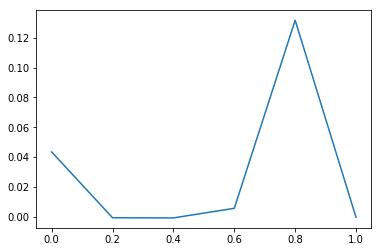

In [176]:
plt.plot(x,y)